# Foreword

For the purpose of Data Science Special Syllabus Report, I am going to use the data from Robot Field for the year 2020. 

# Preprocessing

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import os
import datetime
from copy import copy
import pprint # pretty print
import time

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# To display df nicely in loops
from IPython.display import display 
# display(df1.head()) 
# display(df2.head())

# Display rows and columns Pandas
pd.options.display.max_columns = 100
pd.set_option('display.max_rows',50)

## Importing Data

In [2]:
path = './Data/'
list_data = os.listdir(path)
os.listdir(path)

['band',
 'download.png',
 'feature_importance_CB.pdf',
 'feature_importance_GB.pdf',
 'feature_importance_RF.pdf',
 'heatmap.pdf',
 'raw',
 'Robot_2020_mean_fixed_rows.csv',
 'Robot_2020_median_fixed_rows.csv',
 'Robot_2020_stdev_fixed_rows.csv',
 'Robot_fixed_cols.csv']

In [3]:
import_data = []
import_files = ['Robot_2020_median_fixed_rows.csv']
for csv_data in tqdm(import_files, desc="Importing data", unit="files"):
    if os.path.isfile(os.path.join(path, csv_data)):
        df_name = csv_data[:-4]
        import_data.append(df_name)

        locals()[df_name] = pd.read_csv(path+csv_data)
        print(df_name, '=====', locals()[df_name].shape)
    

Importing data: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.62files/s]

Robot_2020_median_fixed_rows ===== (96, 114)


# Using the median fixed rows dataset

In [4]:
df = Robot_2020_median_fixed_rows.copy()

In [5]:
# Sowing date of the field
sowing = '200420'
maturity = '310720'
heading = '170620'

sowing_date = datetime.datetime.strptime(sowing, '%d%m%y').date()
maturity_date = datetime.datetime.strptime(maturity, '%d%m%y').date()
heading_date =datetime.datetime.strptime(heading, '%d%m%y').date()

In [6]:
# ToDo: Add check for duplicate columns in the df

general_col_names = ['Plot_ID', 'Blue', 'Green', 'Red', 'RedEdge', 'NIR', 'NDVI', 'MTCI', 'EVI']

# list_agg_df
yield_cols = ['GrainYield', 'Days2Heading', 'Days2Maturity']
id_cols_new = ['Plot_ID']

# Counter for location of column in columns list
loc = 0

# Dict for saving the name and location of the yield column
loc_yield_cols = {}

for cols in df.columns.tolist():
    for y_col in yield_cols:
        if not cols.find(y_col):
            loc_yield_cols[cols] = loc
            print(f'\"{cols}\" column in features_df seems like the yield column as it contains the text \"{y_col}\". It is located at location {loc}')
    loc += 1

yield_cols_found = list(loc_yield_cols.keys())
target_cols=yield_cols_found[0]

"GrainYield_180620" column in features_df seems like the yield column as it contains the text "GrainYield". It is located at location 9


In [7]:
df_aoc = df[id_cols_new+yield_cols_found]
# Renaming Grain_Yield Column #custom
df_aoc.columns = [df_aoc.columns[0]]+['GrainYield']
df_aoc.head(2)

,Plot_ID,GrainYield
0,1101,453.658537
1,1102,439.024390


## Filtering df for date that can be used

In [8]:
cols_blue = [x for x in df.columns if 'Blue_' in x]
dates = [x.split('_')[1] for x in cols_blue]
date_fmt = [datetime.datetime.strptime(x, '%d%m%y').date() for x in dates]
# dates
# len(date_fmt)
in_between_dates = []
for d in date_fmt:
    if d >= heading_date and d <= maturity_date:
        in_between_dates.append(d)
in_between_dates

[datetime.date(2020, 6, 18),
 datetime.date(2020, 6, 23),
 datetime.date(2020, 6, 24),
 datetime.date(2020, 6, 25),
 datetime.date(2020, 6, 29),
 datetime.date(2020, 7, 1),
 datetime.date(2020, 7, 7),
 datetime.date(2020, 7, 13),
 datetime.date(2020, 7, 20),
 datetime.date(2020, 7, 22),
 datetime.date(2020, 7, 27),
 datetime.date(2020, 7, 30)]

In [9]:
temp_cols1 = [x for x in df.columns if not '040820' in x]
temp_cols2 = [x for x in temp_cols1 if not '120820' in x]
# temp_cols3 = [x for x in temp_cols2 if not '180620' in x]

df_select = df[temp_cols2]
df_select.head(2)


,Plot_ID,Blue_180620,Green_180620,Red_180620,RedEdge_180620,NIR_180620,NDVI_180620,MTCI_180620,EVI_180620,GrainYield_180620,Blue_230620,Green_230620,Red_230620,RedEdge_230620,NIR_230620,NDVI_230620,MTCI_230620,EVI_230620,Blue_240620,Green_240620,Red_240620,RedEdge_240620,NIR_240620,NDVI_240620,MTCI_240620,EVI_240620,Blue_250620,Green_250620,Red_250620,RedEdge_250620,NIR_250620,NDVI_250620,MTCI_250620,EVI_250620,Blue_290620,Green_290620,Red_290620,RedEdge_290620,NIR_290620,NDVI_290620,MTCI_290620,EVI_290620,Blue_010720,Green_010720,Red_010720,RedEdge_010720,NIR_010720,NDVI_010720,MTCI_010720,EVI_010720,Blue_070720,Green_070720,Red_070720,RedEdge_070720,NIR_070720,NDVI_070720,MTCI_070720,EVI_070720,Blue_130720,Green_130720,Red_130720,RedEdge_130720,NIR_130720,NDVI_130720,MTCI_130720,EVI_130720,Blue_200720,Green_200720,Red_200720,RedEdge_200720,NIR_200720,NDVI_200720,MTCI_200720,EVI_200720,Blue_220720,Green_220720,Red_220720,RedEdge_220720,NIR_220720,NDVI_220720,MTCI_220720,EVI_220720,Blue_270720,Green_270720,Red_270720,RedEdge_270720,NIR_270720,NDVI_270720,MTCI_270720,EVI_270720,Blue_300720,Green_300720,Red_300720,RedEdge_300720,NIR_300720,NDVI_300720,MTCI_300720,EVI_300720
0,1101,0.020172,0.045518,0.031956,0.104009,0.291076,0.752425,3.156992,-0.615805,453.658537,0.031525,0.098336,0.042261,0.162172,0.634124,0.881080,-0.406316,-1.728818,0.018872,0.049369,0.024608,0.112616,0.402543,0.885614,3.262092,-1.065631,0.028579,0.065614,0.046904,0.121527,0.294172,0.724423,2.949702,-0.514457,0.002445,0.005291,0.002453,0.013643,0.042929,0.891991,2.608521,-0.102199,0.021905,0.051635,0.028147,0.142298,0.465755,0.885390,2.803551,-1.261239,0.026941,0.078043,0.059719,0.163123,0.365088,0.713755,1.996877,-0.638697,0.018340,0.067697,0.023631,0.246153,0.735899,0.937665,2.195285,-3.276678,0.024546,0.082166,0.051452,0.182917,0.459972,0.802431,2.067497,-0.988834,0.019306,0.066392,0.047035,0.176781,0.394213,0.787492,1.685444,-0.840385,0.025022,0.068829,0.069010,0.15343,0.289067,0.602283,1.577007,-0.419105,0.025994,0.058859,0.070486,0.190948,0.377660,0.675071,1.651821,-0.619201
1,1102,0.024764,0.052079,0.042080,0.110786,0.262999,0.711122,3.191882,-0.469957,439.024390,0.025550,0.084070,0.036522,0.161120,0.577145,0.886249,-0.457174,-1.621326,0.024412,0.054661,0.030559,0.117232,0.405762,0.860194,3.320230,-0.976404,0.032563,0.066505,0.050314,0.125360,0.285351,0.702292,3.120023,-0.466065,0.003207,0.005747,0.003020,0.013781,0.041950,0.866511,2.609107,-0.097302,0.028108,0.055910,0.035009,0.145149,0.458687,0.858816,2.861652,-1.100831,0.024079,0.078848,0.043090,0.169368,0.410774,0.809001,1.904274,-0.893868,0.019176,0.051398,0.030258,0.135311,0.361238,0.845886,2.162522,-0.858232,0.031326,0.091255,0.063361,0.189308,0.447530,0.757654,1.983066,-0.822572,0.026521,0.076623,0.059252,0.186323,0.388483,0.736908,1.595386,-0.705938,0.023936,0.071961,0.061892,0.16706,0.320667,0.670205,1.389728,-0.525876,0.035946,0.075253,0.089332,0.194962,0.356104,0.598632,1.530140,-0.460115


## ToDo: Identify Dates and index with problems

In [10]:
general_col_names

['Plot_ID', 'Blue', 'Green', 'Red', 'RedEdge', 'NIR', 'NDVI', 'MTCI', 'EVI']

Wall time: 586 ms


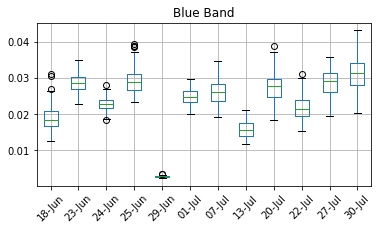

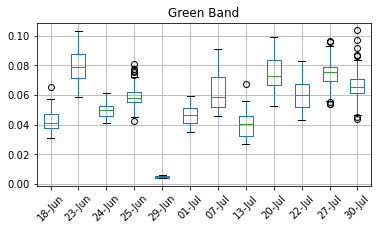

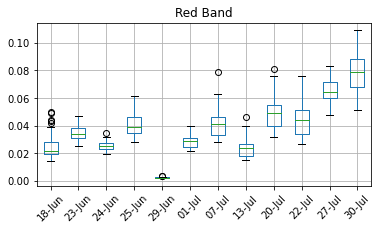

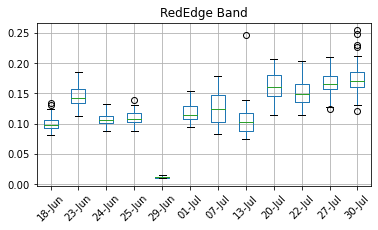

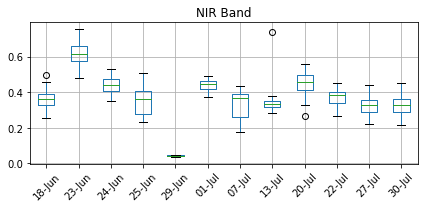

In [11]:
%%time

# base_indices = general_col_names[1:]
base_indices= [ 'Blue', 'Green', 'Red', 'RedEdge', 'NIR']

field_sample = ''
for col in base_indices:
    fig_size=(6,3)
    n_plot = 0
    fig, ax = plt.subplots(1,1, figsize=fig_size)
    plots = [ax]
    
    temp_df = pd.DataFrame()
    for cols in df_select.columns[1:]:
        # Adding required data to a temp dataframe
        if col+'_' in cols:
            date_str = cols.split('_')[1]
            date = datetime.datetime.strptime(date_str, '%d%m%y').date()
            col_name = date.strftime('%d-%b')+'_'+col
            temp_df[col_name] = df_select[cols]
    # Adding field plot to the subplots

    ax_n = plots[n_plot]
    x_labels = [date[:-(len(col)+1)] for date in temp_df.columns.tolist()]
    temp_df.boxplot(ax=ax_n)

    ax_n.set_xticklabels(x_labels, rotation=45)
    ax_n.set_title(field_sample+''+col+' Band')
#     plt.savefig('Data/band/'+col+'.pdf',dpi=500, bbox_inches='tight')

    n_plot += 1
plt.tight_layout()

It looks like that the data from 29 June does not follow the trends of the data for several indices. So, it can be dropped.

## Delete data from dates with problems, i.e. are out of trend

In [12]:
temp_cols1 = [x for x in df_select.columns if not '290620' in x]
# temp_cols2 = [x for x in temp_cols1 if not '120820' in x]
# temp_cols3 = [x for x in temp_cols2 if not '180620' in x]
df_select = df_select[temp_cols1]
df_select.head(2)
df_select.shape

(96, 90)

# Integrating the data from different dates using simpsonian integration

In [13]:
from scipy.integrate import simps
from numpy import trapz

## Calculating AOC and creating new df with calculated values

In [14]:

for col_name in general_col_names[1:]:
    list_simp = []
    temp_cols = [x for x in df_select.columns if col_name+'_' in x]
    temp_dates = [datetime.datetime.strptime(date.split('_')[1], '%d%m%y').date() for date in temp_cols]
    days_sow = [(x-sowing_date).days for x in temp_dates]

    for sample in range(df_select.shape[0]):

        temp_entries= [df_select[x][sample] for x in temp_cols]
        list_simp.append(simps(temp_entries,days_sow))
#     print(temp_cols)

#     plt.plot(list_simp)
#     plt.show()
    df_aoc[col_name] = list_simp
df_aoc

<ipython-input-14-852067d104a2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aoc[col_name] = list_simp


,Plot_ID,GrainYield,Blue,Green,Red,RedEdge,NIR,NDVI,MTCI,EVI
0,1101,453.658537,1.140449,3.289495,2.174728,7.145957,18.671901,31.860059,70.468431,-46.515493
1,1102,439.024390,1.162107,3.216190,2.130707,6.837899,16.790288,32.022578,68.874278,-35.169059
2,1103,409.756098,1.303988,3.406214,2.389348,6.903629,16.682318,30.841366,69.318976,-32.215940
3,1104,474.796748,1.188988,3.164827,2.124763,6.547565,16.298964,32.025119,72.659576,-32.965596
4,1105,411.382114,1.278810,3.296357,2.297247,6.898202,16.332953,31.226680,70.407240,-32.135993
...,...,...,...,...,...,...,...,...,...,...
91,1808,429.268293,1.237133,3.043614,2.077520,6.070051,15.419659,31.712191,66.352501,-30.321913
92,1809,414.634146,1.196637,2.983624,1.928795,5.675383,15.753819,32.444795,69.638629,-32.446815
93,1810,460.162602,1.286602,3.064071,2.106050,5.842421,15.347268,31.314367,69.046737,-30.114992
94,1811,443.902439,1.309689,3.102665,2.166354,6.061913,15.342692,31.347682,68.664876,-28.978802


# Data Trends Visualisation

## Correlation heatmap of indices with target

In [15]:

sns.diverging_palette(331, 129, as_cmap=True)


In [16]:
pal=['PRGn', 'PiYG', 'PuOr', 'RdBu','RdYlBu','RdYlGn','Spectral']

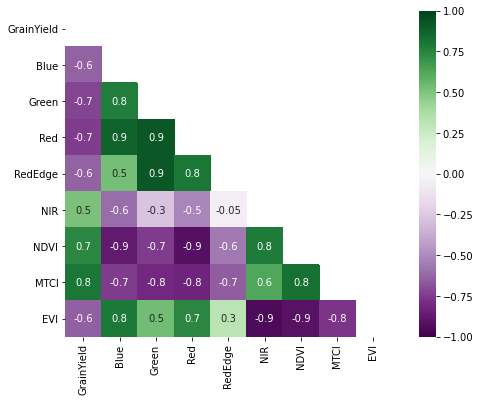

In [17]:
correlation = df_aoc.iloc[:,1:].corr()
matrix = np.triu(correlation)

plt.figure(figsize=(10,6))
sns.heatmap(correlation, cmap='PRGn', annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0 ,square=True, mask=matrix)
# plt.savefig('Data/heatmap.pdf',dpi=500, bbox_inches='tight')
plt.show()


# Model Training

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time, datetime
from datetime import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.linear_model import Lasso
from catboost import CatBoostRegressor


# Preparing data for ML

In [19]:
features_df = df_aoc.copy()
features_df.columns

Index(['Plot_ID', 'GrainYield', 'Blue', 'Green', 'Red', 'RedEdge', 'NIR',
       'NDVI', 'MTCI', 'EVI'],
      dtype='object')

In [20]:
# ToDo: Add check for duplicate columns in the features_df

# list_agg_df
yield_cols = ['GrainYield', 'Days2Heading', 'Days2Maturity']
id_cols_new = ['Plot_ID']

# Counter for location of column in columns list
loc = 0

# Dict for saving the name and location of the yield column
loc_yield_cols = {}

for cols in features_df.columns.tolist():
    for y_col in yield_cols:
        if not cols.find(y_col):
            loc_yield_cols[cols] = loc
            print(f'\"{cols}\" column in features_df seems like the yield column as it contains the text \"{y_col}\". It is located at location {loc}')
    loc += 1

yield_cols_found = list(loc_yield_cols.keys())
target_cols=yield_cols_found[0]

"GrainYield" column in features_df seems like the yield column as it contains the text "GrainYield". It is located at location 1


In [21]:
#==============================================================================
# Initializing the comments to be appended to results
#==============================================================================

comments = []
comments.append('Median')
comments.append('EVI')
comments.append('Simpsonian Integration')
comments.append('Droped dates 040820, 120820, 290620')

In [22]:
#==============================================================================
# Split dataframe into data and target
#==============================================================================

temp_X = features_df.drop(columns = yield_cols_found+id_cols_new)
y = features_df[target_cols]
# y = features_df[target_cols].values.flatten()
comments.append('Drop Plot_ID.')
comments.append('GrainYield Target.')
X = temp_X.copy()


In [23]:
temp_X.head(2)

,Blue,Green,Red,RedEdge,NIR,NDVI,MTCI,EVI
0,1.140449,3.289495,2.174728,7.145957,18.671901,31.860059,70.468431,-46.515493
1,1.162107,3.216190,2.130707,6.837899,16.790288,32.022578,68.874278,-35.169059


## Declaring functions

In [24]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(5,3.5))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], )
    #Add chart labels
    plt.title(model_type + 'Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.savefig('Data/feature_importance_'+model_type+'.pdf',dpi=500, bbox_inches='tight')
    display(fi_df)

# Predictions

In [26]:
param=[x/10 for x in range(25,100)]
param=[x for x in range(0,1000, 100)]
param=[1]
scores={}
for pr in tqdm(param):
    accuracy = {}
    R2 = []
    RMSE=[]
    MAE=[]
    for rs in range(10):
        #==============================================================================
        # Create separate train/test splits
        #==============================================================================
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
        X_train.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)
        sc = StandardScaler()
        sc.fit(X_train)
        X_train_std = sc.transform(X_train)
        X_test_std = sc.transform(X_test)
        #==============================================================================
        # Training best performing models
        #==============================================================================
        model = Lasso(alpha= 4.5)
        model.fit(X_train_std, y_train)
        y_pred = model.predict(X_test_std)
        R2.append(r2_score(y_test, y_pred))
        MAE.append(mean_absolute_error(y_test, y_pred))
        RMSE.append(mean_squared_error(y_test, y_pred, squared=False))
    accuracy['R2'] = R2
    accuracy['MAE'] = MAE
    accuracy['RMSE'] = RMSE

    for k, s in accuracy.items():
        scores[k]=(sum(s)/len(s))
scores

100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.51it/s]


{'R2': 0.6165133338737417,
 'MAE': 46.29216449139247,
 'RMSE': 58.105006228173394}

In [27]:
# plot_feature_importance(model.feature_importances_,X_train.columns,'CatBoost Regressor')


AttributeError: 'Lasso' object has no attribute 'feature_importances_'

In [28]:
param = [int(x) for x in range(8, 25)]
param=[1]
scores={}
for pr in tqdm(param):
    accuracy = {}
    R2 = []
    RMSE=[]
    MAE=[]
    for rs in range(10):
        #==============================================================================
        # Create separate train/test splits
        #==============================================================================
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
        X_train.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)
        sc = StandardScaler()
        X_train_std = sc.fit_transform(X_train)
        X_test_std = sc.transform(X_test)
        #==============================================================================
        # Training best performing models
        #==============================================================================
        model = RandomForestRegressor(max_depth=250, min_samples_split=14,min_samples_leaf =3, random_state=1, n_jobs = -1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)    
        R2.append(r2_score(y_test, y_pred))
        MAE.append(mean_absolute_error(y_test, y_pred))
        RMSE.append(mean_squared_error(y_test, y_pred, squared=False))
    accuracy['R2'] = R2
    accuracy['MAE'] = MAE
    accuracy['RMSE'] = RMSE

    for k, s in accuracy.items():
        scores[k]=(sum(s)/len(s))
scores

100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


{'R2': 0.7359203255994402, 'MAE': 38.20716473821461, 'RMSE': 48.208728328129}

,feature_names,feature_importance
6,MTCI,0.574145
5,NDVI,0.242455
2,Red,0.106342
0,Blue,0.045068
4,NIR,0.013788
7,EVI,0.008850
3,RedEdge,0.007053
1,Green,0.002298


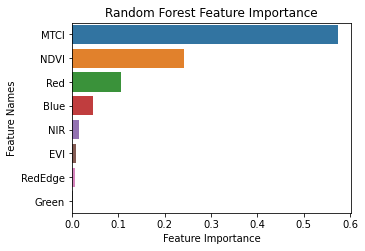

In [29]:

plot_feature_importance(model.feature_importances_,X_train.columns,'Random Forest ')


In [30]:
param=[x/10 for x in range(1,11)]
param=[1]

scores={}
for pr in tqdm(param):
    accuracy = {}
    R2 = []
    RMSE=[]
    MAE=[]
    for rs in range(10):
        # Create separate train/test splits
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
        X_train.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)
        sc = StandardScaler()
        X_train_std = sc.fit_transform(X_train)
        X_test_std = sc.transform(X_test)
        # Training best performing models
        model = GradientBoostingRegressor(subsample=0.8,learning_rate=0.4, random_state=500)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)   
        R2.append(r2_score(y_test, y_pred))
        MAE.append(mean_absolute_error(y_test, y_pred))
        RMSE.append(mean_squared_error(y_test, y_pred, squared=False))
    accuracy['R2'] = R2
    accuracy['MAE'] = MAE
    accuracy['RMSE'] = RMSE

    for k, s in accuracy.items():
        scores[k]=(sum(s)/len(s))
scores
# Changing the number of n_estimator doesnt affect the resutls


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


{'R2': 0.7139824275506774, 'MAE': 38.93835323340685, 'RMSE': 49.95671261699765}

,feature_names,feature_importance
6,MTCI,0.517352
5,NDVI,0.200786
7,EVI,0.076553
2,Red,0.074000
0,Blue,0.065108
4,NIR,0.026665
1,Green,0.022449
3,RedEdge,0.017087


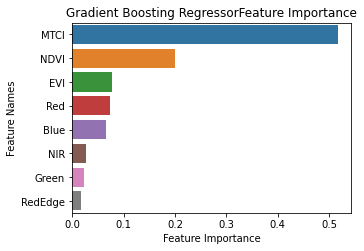

In [34]:
plot_feature_importance(model.feature_importances_,X_train.columns,'Gradient Boosting Regressor')


In [38]:
param=[x for x in range(8,15,2 ) ]
param=[1]
scores={}
for pr in tqdm(param):
    accuracy = {}
    R2 = []
    RMSE=[]
    MAE=[]
    for rs in range(10):
        # Create separate train/test splits
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
        X_train.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)
        # Training best performing models
        model = CatBoostRegressor(depth=8)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)   
        R2.append(r2_score(y_test, y_pred))
        MAE.append(mean_absolute_error(y_test, y_pred))
        RMSE.append(mean_squared_error(y_test, y_pred, squared=False))
    accuracy['R2'] = R2
    accuracy['MAE'] = MAE
    accuracy['RMSE'] = RMSE

    for k, s in accuracy.items():
        scores[k]=(sum(s)/len(s))
scores

  0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Learning rate set to 0.024124
0:	learn: 100.7446504	total: 1.83ms	remaining: 1.83s
1:	learn: 99.4226747	total: 2.96ms	remaining: 1.48s
2:	learn: 98.1251605	total: 4.03ms	remaining: 1.34s
3:	learn: 96.8997002	total: 5.13ms	remaining: 1.28s
4:	learn: 95.7013712	total: 6.19ms	remaining: 1.23s
5:	learn: 94.5305492	total: 7.24ms	remaining: 1.2s
6:	learn: 93.5066251	total: 8.29ms	remaining: 1.18s
7:	learn: 92.3950261	total: 9.44ms	remaining: 1.17s
8:	learn: 91.3296282	total: 10.7ms	remaining: 1.17s
9:	learn: 90.2086980	total: 11.8ms	remaining: 1.17s
10:	learn: 89.2080041	total: 13ms	remaining: 1.16s
11:	learn: 88.0626022	total: 14.2ms	remaining: 1.17s
12:	learn: 87.0955304	total: 15.3ms	remaining: 1.16s
13:	learn: 86.0270899	total: 16.8ms	remaining: 1.18s
14:	learn: 84.9758449	total: 18.1ms	remaining: 1.19s
15:	learn: 83.8379701	total: 19.7ms	remaining: 1.21s
16:	learn: 82.9077959	total: 21ms	remaining: 1.21s
17:	learn: 81.7411432	total: 22.4ms	remaining: 1.22s
18:	learn: 80.7718548	total: 2

242:	learn: 18.3284507	total: 331ms	remaining: 1.03s
243:	learn: 18.2361106	total: 332ms	remaining: 1.03s
244:	learn: 18.1800419	total: 334ms	remaining: 1.03s
245:	learn: 18.1264748	total: 336ms	remaining: 1.03s
246:	learn: 18.0566079	total: 336ms	remaining: 1.02s
247:	learn: 17.9935895	total: 338ms	remaining: 1.02s
248:	learn: 17.9235143	total: 340ms	remaining: 1.02s
249:	learn: 17.8658482	total: 341ms	remaining: 1.02s
250:	learn: 17.7788831	total: 343ms	remaining: 1.02s
251:	learn: 17.7131877	total: 344ms	remaining: 1.02s
252:	learn: 17.6329064	total: 346ms	remaining: 1.02s
253:	learn: 17.5700795	total: 347ms	remaining: 1.02s
254:	learn: 17.4945786	total: 348ms	remaining: 1.02s
255:	learn: 17.4287084	total: 350ms	remaining: 1.02s
256:	learn: 17.3577671	total: 352ms	remaining: 1.02s
257:	learn: 17.2641716	total: 353ms	remaining: 1.02s
258:	learn: 17.1998740	total: 355ms	remaining: 1.02s
259:	learn: 17.1298469	total: 356ms	remaining: 1.01s
260:	learn: 17.0048653	total: 358ms	remaining:

512:	learn: 6.9205965	total: 670ms	remaining: 636ms
513:	learn: 6.9010518	total: 672ms	remaining: 635ms
514:	learn: 6.8836193	total: 673ms	remaining: 634ms
515:	learn: 6.8402935	total: 675ms	remaining: 633ms
516:	learn: 6.7975284	total: 676ms	remaining: 632ms
517:	learn: 6.7588217	total: 678ms	remaining: 631ms
518:	learn: 6.7206900	total: 680ms	remaining: 630ms
519:	learn: 6.6807183	total: 681ms	remaining: 629ms
520:	learn: 6.6435049	total: 683ms	remaining: 628ms
521:	learn: 6.6022465	total: 684ms	remaining: 627ms
522:	learn: 6.5635062	total: 686ms	remaining: 626ms
523:	learn: 6.5232778	total: 688ms	remaining: 625ms
524:	learn: 6.4855201	total: 689ms	remaining: 624ms
525:	learn: 6.4674827	total: 691ms	remaining: 623ms
526:	learn: 6.4491911	total: 693ms	remaining: 622ms
527:	learn: 6.4381965	total: 695ms	remaining: 621ms
528:	learn: 6.3992160	total: 696ms	remaining: 620ms
529:	learn: 6.3830168	total: 697ms	remaining: 618ms
530:	learn: 6.3651949	total: 698ms	remaining: 617ms
531:	learn: 

761:	learn: 2.8155289	total: 1.01s	remaining: 315ms
762:	learn: 2.8064117	total: 1.01s	remaining: 314ms
763:	learn: 2.7973889	total: 1.01s	remaining: 313ms
764:	learn: 2.7875268	total: 1.01s	remaining: 312ms
765:	learn: 2.7780089	total: 1.02s	remaining: 311ms
766:	learn: 2.7691475	total: 1.02s	remaining: 310ms
767:	learn: 2.7586336	total: 1.02s	remaining: 309ms
768:	learn: 2.7498433	total: 1.02s	remaining: 307ms
769:	learn: 2.7394359	total: 1.02s	remaining: 306ms
770:	learn: 2.7307160	total: 1.03s	remaining: 305ms
771:	learn: 2.7215241	total: 1.03s	remaining: 304ms
772:	learn: 2.7118887	total: 1.03s	remaining: 303ms
773:	learn: 2.7027780	total: 1.03s	remaining: 302ms
774:	learn: 2.6925291	total: 1.03s	remaining: 301ms
775:	learn: 2.6840313	total: 1.04s	remaining: 299ms
776:	learn: 2.6756219	total: 1.04s	remaining: 298ms
777:	learn: 2.6654560	total: 1.04s	remaining: 297ms
778:	learn: 2.6570557	total: 1.04s	remaining: 296ms
779:	learn: 2.6469915	total: 1.05s	remaining: 295ms
780:	learn: 

959:	learn: 1.4333924	total: 1.34s	remaining: 56.1ms
960:	learn: 1.4299264	total: 1.35s	remaining: 54.7ms
961:	learn: 1.4251287	total: 1.35s	remaining: 53.3ms
962:	learn: 1.4203812	total: 1.35s	remaining: 51.9ms
963:	learn: 1.4145870	total: 1.35s	remaining: 50.5ms
964:	learn: 1.4111678	total: 1.35s	remaining: 49.1ms
965:	learn: 1.4064573	total: 1.35s	remaining: 47.7ms
966:	learn: 1.4000657	total: 1.36s	remaining: 46.3ms
967:	learn: 1.3944046	total: 1.36s	remaining: 44.9ms
968:	learn: 1.3901714	total: 1.36s	remaining: 43.5ms
969:	learn: 1.3864593	total: 1.36s	remaining: 42.1ms
970:	learn: 1.3818683	total: 1.36s	remaining: 40.7ms
971:	learn: 1.3781857	total: 1.36s	remaining: 39.3ms
972:	learn: 1.3740916	total: 1.37s	remaining: 37.9ms
973:	learn: 1.3695098	total: 1.37s	remaining: 36.5ms
974:	learn: 1.3648742	total: 1.37s	remaining: 35.1ms
975:	learn: 1.3602837	total: 1.37s	remaining: 33.7ms
976:	learn: 1.3566542	total: 1.37s	remaining: 32.3ms
977:	learn: 1.3520962	total: 1.37s	remaining: 

141:	learn: 31.9478617	total: 205ms	remaining: 1.24s
142:	learn: 31.8219533	total: 206ms	remaining: 1.24s
143:	learn: 31.6692614	total: 208ms	remaining: 1.24s
144:	learn: 31.5472343	total: 209ms	remaining: 1.23s
145:	learn: 31.4047482	total: 211ms	remaining: 1.23s
146:	learn: 31.2547822	total: 213ms	remaining: 1.24s
147:	learn: 31.0539461	total: 215ms	remaining: 1.24s
148:	learn: 30.9473519	total: 217ms	remaining: 1.24s
149:	learn: 30.7872727	total: 218ms	remaining: 1.24s
150:	learn: 30.6557375	total: 220ms	remaining: 1.24s
151:	learn: 30.4850558	total: 222ms	remaining: 1.24s
152:	learn: 30.3487870	total: 224ms	remaining: 1.24s
153:	learn: 30.1700918	total: 225ms	remaining: 1.24s
154:	learn: 30.0567378	total: 227ms	remaining: 1.24s
155:	learn: 29.8879371	total: 229ms	remaining: 1.24s
156:	learn: 29.7234124	total: 230ms	remaining: 1.23s
157:	learn: 29.5731444	total: 231ms	remaining: 1.23s
158:	learn: 29.4225427	total: 233ms	remaining: 1.23s
159:	learn: 29.2681963	total: 234ms	remaining:

378:	learn: 10.8891690	total: 541ms	remaining: 887ms
379:	learn: 10.8235493	total: 543ms	remaining: 886ms
380:	learn: 10.7968331	total: 545ms	remaining: 885ms
381:	learn: 10.7711321	total: 547ms	remaining: 885ms
382:	learn: 10.7067351	total: 549ms	remaining: 884ms
383:	learn: 10.6732018	total: 550ms	remaining: 883ms
384:	learn: 10.6468038	total: 552ms	remaining: 882ms
385:	learn: 10.6031589	total: 554ms	remaining: 882ms
386:	learn: 10.5683062	total: 556ms	remaining: 881ms
387:	learn: 10.5421811	total: 558ms	remaining: 880ms
388:	learn: 10.4941178	total: 560ms	remaining: 879ms
389:	learn: 10.4686265	total: 561ms	remaining: 878ms
390:	learn: 10.4364528	total: 563ms	remaining: 877ms
391:	learn: 10.4112745	total: 565ms	remaining: 877ms
392:	learn: 10.3866693	total: 566ms	remaining: 875ms
393:	learn: 10.3510139	total: 568ms	remaining: 873ms
394:	learn: 10.2899273	total: 569ms	remaining: 871ms
395:	learn: 10.2652397	total: 570ms	remaining: 869ms
396:	learn: 10.2193246	total: 571ms	remaining:

611:	learn: 4.9653154	total: 879ms	remaining: 557ms
612:	learn: 4.9457347	total: 881ms	remaining: 556ms
613:	learn: 4.9174051	total: 883ms	remaining: 555ms
614:	learn: 4.9072666	total: 884ms	remaining: 554ms
615:	learn: 4.8843049	total: 886ms	remaining: 552ms
616:	learn: 4.8613374	total: 888ms	remaining: 551ms
617:	learn: 4.8338064	total: 889ms	remaining: 550ms
618:	learn: 4.8114967	total: 891ms	remaining: 548ms
619:	learn: 4.8015664	total: 892ms	remaining: 547ms
620:	learn: 4.7771258	total: 894ms	remaining: 546ms
621:	learn: 4.7504035	total: 896ms	remaining: 544ms
622:	learn: 4.7240954	total: 897ms	remaining: 543ms
623:	learn: 4.7100530	total: 899ms	remaining: 542ms
624:	learn: 4.6887105	total: 900ms	remaining: 540ms
625:	learn: 4.6650738	total: 901ms	remaining: 539ms
626:	learn: 4.6440596	total: 903ms	remaining: 537ms
627:	learn: 4.6303558	total: 905ms	remaining: 536ms
628:	learn: 4.6051588	total: 907ms	remaining: 535ms
629:	learn: 4.5890210	total: 909ms	remaining: 534ms
630:	learn: 

838:	learn: 2.2082229	total: 1.22s	remaining: 234ms
839:	learn: 2.2028455	total: 1.22s	remaining: 232ms
840:	learn: 2.1936633	total: 1.22s	remaining: 231ms
841:	learn: 2.1874213	total: 1.22s	remaining: 229ms
842:	learn: 2.1783575	total: 1.22s	remaining: 228ms
843:	learn: 2.1721723	total: 1.23s	remaining: 227ms
844:	learn: 2.1597735	total: 1.23s	remaining: 225ms
845:	learn: 2.1537009	total: 1.23s	remaining: 224ms
846:	learn: 2.1445912	total: 1.23s	remaining: 222ms
847:	learn: 2.1385736	total: 1.23s	remaining: 221ms
848:	learn: 2.1264837	total: 1.24s	remaining: 220ms
849:	learn: 2.1175462	total: 1.24s	remaining: 218ms
850:	learn: 2.1116229	total: 1.24s	remaining: 217ms
851:	learn: 2.1057683	total: 1.24s	remaining: 216ms
852:	learn: 2.0939792	total: 1.24s	remaining: 214ms
853:	learn: 2.0877973	total: 1.24s	remaining: 213ms
854:	learn: 2.0816954	total: 1.25s	remaining: 211ms
855:	learn: 2.0755825	total: 1.25s	remaining: 210ms
856:	learn: 2.0706514	total: 1.25s	remaining: 209ms
857:	learn: 

16:	learn: 83.7252360	total: 23.1ms	remaining: 1.34s
17:	learn: 82.8470772	total: 24.4ms	remaining: 1.33s
18:	learn: 81.8946394	total: 26.1ms	remaining: 1.35s
19:	learn: 80.9361410	total: 26.8ms	remaining: 1.31s
20:	learn: 79.8983023	total: 28.5ms	remaining: 1.33s
21:	learn: 79.0705123	total: 30.2ms	remaining: 1.34s
22:	learn: 77.9936511	total: 30.9ms	remaining: 1.31s
23:	learn: 77.2252253	total: 32.7ms	remaining: 1.33s
24:	learn: 76.3203823	total: 34.4ms	remaining: 1.34s
25:	learn: 75.5521318	total: 36.1ms	remaining: 1.35s
26:	learn: 74.6831649	total: 37.8ms	remaining: 1.36s
27:	learn: 73.7498679	total: 39.6ms	remaining: 1.37s
28:	learn: 73.0101746	total: 41.4ms	remaining: 1.39s
29:	learn: 72.2225965	total: 42.8ms	remaining: 1.38s
30:	learn: 71.4661580	total: 44.8ms	remaining: 1.4s
31:	learn: 70.7326198	total: 46.2ms	remaining: 1.4s
32:	learn: 70.0154388	total: 47.5ms	remaining: 1.39s
33:	learn: 69.3252811	total: 48.6ms	remaining: 1.38s
34:	learn: 68.5571042	total: 49.7ms	remaining: 1

263:	learn: 18.3604473	total: 361ms	remaining: 1s
264:	learn: 18.2923315	total: 362ms	remaining: 1s
265:	learn: 18.1848049	total: 364ms	remaining: 1s
266:	learn: 18.1180747	total: 366ms	remaining: 1s
267:	learn: 18.0781961	total: 367ms	remaining: 1s
268:	learn: 18.0105199	total: 369ms	remaining: 1s
269:	learn: 17.9686096	total: 371ms	remaining: 1s
270:	learn: 17.9026989	total: 373ms	remaining: 1s
271:	learn: 17.8263980	total: 374ms	remaining: 1s
272:	learn: 17.7695615	total: 376ms	remaining: 1s
273:	learn: 17.7055628	total: 378ms	remaining: 1s
274:	learn: 17.6683705	total: 379ms	remaining: 1s
275:	learn: 17.5846033	total: 381ms	remaining: 1s
276:	learn: 17.5247224	total: 383ms	remaining: 1000ms
277:	learn: 17.5028689	total: 384ms	remaining: 997ms
278:	learn: 17.4285090	total: 386ms	remaining: 997ms
279:	learn: 17.3747756	total: 388ms	remaining: 997ms
280:	learn: 17.3113001	total: 390ms	remaining: 997ms
281:	learn: 17.2591885	total: 391ms	remaining: 996ms
282:	learn: 17.1503793	total: 3

475:	learn: 8.7317549	total: 700ms	remaining: 770ms
476:	learn: 8.7123570	total: 702ms	remaining: 770ms
477:	learn: 8.6919241	total: 704ms	remaining: 769ms
478:	learn: 8.6510176	total: 706ms	remaining: 768ms
479:	learn: 8.6308135	total: 708ms	remaining: 766ms
480:	learn: 8.6134674	total: 709ms	remaining: 765ms
481:	learn: 8.5840732	total: 711ms	remaining: 764ms
482:	learn: 8.5642162	total: 713ms	remaining: 763ms
483:	learn: 8.5454521	total: 715ms	remaining: 762ms
484:	learn: 8.5163542	total: 717ms	remaining: 761ms
485:	learn: 8.4968164	total: 718ms	remaining: 760ms
486:	learn: 8.4680590	total: 720ms	remaining: 758ms
487:	learn: 8.4487311	total: 722ms	remaining: 758ms
488:	learn: 8.4203097	total: 724ms	remaining: 756ms
489:	learn: 8.4026824	total: 725ms	remaining: 754ms
490:	learn: 8.3745662	total: 727ms	remaining: 754ms
491:	learn: 8.3570727	total: 729ms	remaining: 752ms
492:	learn: 8.3381629	total: 731ms	remaining: 752ms
493:	learn: 8.3103152	total: 732ms	remaining: 750ms
494:	learn: 

720:	learn: 3.8418853	total: 1.03s	remaining: 401ms
721:	learn: 3.8272426	total: 1.04s	remaining: 399ms
722:	learn: 3.8100784	total: 1.04s	remaining: 398ms
723:	learn: 3.7956372	total: 1.04s	remaining: 397ms
724:	learn: 3.7787102	total: 1.04s	remaining: 395ms
725:	learn: 3.7680509	total: 1.04s	remaining: 394ms
726:	learn: 3.7523018	total: 1.04s	remaining: 393ms
727:	learn: 3.7367644	total: 1.05s	remaining: 391ms
728:	learn: 3.7244625	total: 1.05s	remaining: 390ms
729:	learn: 3.7091168	total: 1.05s	remaining: 389ms
730:	learn: 3.6969409	total: 1.05s	remaining: 387ms
731:	learn: 3.6817838	total: 1.05s	remaining: 386ms
732:	learn: 3.6697321	total: 1.06s	remaining: 385ms
733:	learn: 3.6547606	total: 1.06s	remaining: 384ms
734:	learn: 3.6428314	total: 1.06s	remaining: 382ms
735:	learn: 3.6310408	total: 1.06s	remaining: 381ms
736:	learn: 3.6162343	total: 1.06s	remaining: 379ms
737:	learn: 3.6045631	total: 1.06s	remaining: 378ms
738:	learn: 3.5899365	total: 1.06s	remaining: 376ms
739:	learn: 

926:	learn: 1.9303107	total: 1.37s	remaining: 108ms
927:	learn: 1.9220056	total: 1.37s	remaining: 107ms
928:	learn: 1.9150638	total: 1.38s	remaining: 105ms
929:	learn: 1.9109734	total: 1.38s	remaining: 104ms
930:	learn: 1.9069444	total: 1.38s	remaining: 102ms
931:	learn: 1.9036457	total: 1.38s	remaining: 101ms
932:	learn: 1.9003902	total: 1.38s	remaining: 99.4ms
933:	learn: 1.8964752	total: 1.39s	remaining: 97.9ms
934:	learn: 1.8932863	total: 1.39s	remaining: 96.4ms
935:	learn: 1.8901392	total: 1.39s	remaining: 95ms
936:	learn: 1.8847871	total: 1.39s	remaining: 93.5ms
937:	learn: 1.8816706	total: 1.39s	remaining: 92.1ms
938:	learn: 1.8763631	total: 1.4s	remaining: 90.6ms
939:	learn: 1.8732768	total: 1.4s	remaining: 89.1ms
940:	learn: 1.8695341	total: 1.4s	remaining: 87.6ms
941:	learn: 1.8665108	total: 1.4s	remaining: 86.1ms
942:	learn: 1.8635271	total: 1.4s	remaining: 84.7ms
943:	learn: 1.8582532	total: 1.4s	remaining: 83.2ms
944:	learn: 1.8552983	total: 1.4s	remaining: 81.7ms
945:	lea

120:	learn: 37.7815896	total: 171ms	remaining: 1.25s
121:	learn: 37.5794267	total: 173ms	remaining: 1.25s
122:	learn: 37.3733885	total: 174ms	remaining: 1.24s
123:	learn: 37.1482667	total: 176ms	remaining: 1.24s
124:	learn: 36.9784921	total: 177ms	remaining: 1.24s
125:	learn: 36.7839996	total: 179ms	remaining: 1.24s
126:	learn: 36.5795777	total: 180ms	remaining: 1.24s
127:	learn: 36.3481635	total: 182ms	remaining: 1.24s
128:	learn: 36.1336237	total: 184ms	remaining: 1.24s
129:	learn: 35.8804961	total: 185ms	remaining: 1.24s
130:	learn: 35.7196641	total: 187ms	remaining: 1.24s
131:	learn: 35.5032710	total: 189ms	remaining: 1.24s
132:	learn: 35.3697886	total: 190ms	remaining: 1.24s
133:	learn: 35.1895339	total: 191ms	remaining: 1.24s
134:	learn: 35.0118850	total: 193ms	remaining: 1.24s
135:	learn: 34.8078306	total: 195ms	remaining: 1.24s
136:	learn: 34.5955676	total: 196ms	remaining: 1.24s
137:	learn: 34.3987548	total: 198ms	remaining: 1.23s
138:	learn: 34.2082785	total: 199ms	remaining:

330:	learn: 12.8782114	total: 513ms	remaining: 1.04s
331:	learn: 12.8256663	total: 515ms	remaining: 1.04s
332:	learn: 12.7510868	total: 517ms	remaining: 1.03s
333:	learn: 12.7017003	total: 519ms	remaining: 1.03s
334:	learn: 12.6543954	total: 521ms	remaining: 1.03s
335:	learn: 12.6064771	total: 522ms	remaining: 1.03s
336:	learn: 12.5349127	total: 524ms	remaining: 1.03s
337:	learn: 12.4693466	total: 526ms	remaining: 1.03s
338:	learn: 12.3972088	total: 529ms	remaining: 1.03s
339:	learn: 12.3451604	total: 531ms	remaining: 1.03s
340:	learn: 12.2709163	total: 533ms	remaining: 1.03s
341:	learn: 12.2199613	total: 535ms	remaining: 1.03s
342:	learn: 12.1547464	total: 537ms	remaining: 1.03s
343:	learn: 12.1073375	total: 539ms	remaining: 1.03s
344:	learn: 12.0416163	total: 541ms	remaining: 1.03s
345:	learn: 11.9754019	total: 544ms	remaining: 1.03s
346:	learn: 11.9281274	total: 545ms	remaining: 1.03s
347:	learn: 11.8694752	total: 547ms	remaining: 1.02s
348:	learn: 11.8237531	total: 548ms	remaining:

568:	learn: 5.6586907	total: 850ms	remaining: 644ms
569:	learn: 5.6470684	total: 851ms	remaining: 642ms
570:	learn: 5.6377145	total: 852ms	remaining: 640ms
571:	learn: 5.6284926	total: 854ms	remaining: 639ms
572:	learn: 5.6042646	total: 856ms	remaining: 638ms
573:	learn: 5.5792048	total: 857ms	remaining: 636ms
574:	learn: 5.5676290	total: 858ms	remaining: 634ms
575:	learn: 5.5561819	total: 859ms	remaining: 632ms
576:	learn: 5.5471646	total: 861ms	remaining: 631ms
577:	learn: 5.5382745	total: 862ms	remaining: 630ms
578:	learn: 5.5116069	total: 864ms	remaining: 628ms
579:	learn: 5.4872056	total: 866ms	remaining: 627ms
580:	learn: 5.4758055	total: 867ms	remaining: 625ms
581:	learn: 5.4691182	total: 868ms	remaining: 624ms
582:	learn: 5.4604572	total: 870ms	remaining: 622ms
583:	learn: 5.4373434	total: 871ms	remaining: 621ms
584:	learn: 5.4134844	total: 872ms	remaining: 619ms
585:	learn: 5.4021307	total: 873ms	remaining: 617ms
586:	learn: 5.3955991	total: 874ms	remaining: 615ms
587:	learn: 

821:	learn: 2.4901476	total: 1.19s	remaining: 258ms
822:	learn: 2.4821528	total: 1.19s	remaining: 256ms
823:	learn: 2.4764918	total: 1.19s	remaining: 255ms
824:	learn: 2.4717083	total: 1.2s	remaining: 254ms
825:	learn: 2.4641343	total: 1.2s	remaining: 252ms
826:	learn: 2.4566518	total: 1.2s	remaining: 251ms
827:	learn: 2.4487284	total: 1.2s	remaining: 249ms
828:	learn: 2.4408942	total: 1.2s	remaining: 248ms
829:	learn: 2.4334535	total: 1.2s	remaining: 247ms
830:	learn: 2.4256834	total: 1.21s	remaining: 245ms
831:	learn: 2.4135474	total: 1.21s	remaining: 244ms
832:	learn: 2.4040140	total: 1.21s	remaining: 242ms
833:	learn: 2.3946027	total: 1.21s	remaining: 241ms
834:	learn: 2.3837836	total: 1.21s	remaining: 240ms
835:	learn: 2.3728901	total: 1.21s	remaining: 238ms
836:	learn: 2.3622522	total: 1.22s	remaining: 237ms
837:	learn: 2.3569503	total: 1.22s	remaining: 236ms
838:	learn: 2.3523326	total: 1.22s	remaining: 234ms
839:	learn: 2.3425235	total: 1.22s	remaining: 233ms
840:	learn: 2.3380

0:	learn: 101.1064425	total: 2.06ms	remaining: 2.05s
1:	learn: 99.8787248	total: 3.87ms	remaining: 1.93s
2:	learn: 98.6848703	total: 5.62ms	remaining: 1.87s
3:	learn: 97.4207059	total: 7.49ms	remaining: 1.86s
4:	learn: 96.1688737	total: 9.49ms	remaining: 1.89s
5:	learn: 94.9280625	total: 11.4ms	remaining: 1.89s
6:	learn: 93.9290535	total: 13.2ms	remaining: 1.88s
7:	learn: 92.7639006	total: 15.1ms	remaining: 1.87s
8:	learn: 91.7919376	total: 17ms	remaining: 1.87s
9:	learn: 90.6427630	total: 18.6ms	remaining: 1.84s
10:	learn: 89.5820919	total: 20.8ms	remaining: 1.87s
11:	learn: 88.3549614	total: 22.4ms	remaining: 1.85s
12:	learn: 87.3465261	total: 24.1ms	remaining: 1.83s
13:	learn: 86.1850333	total: 25.8ms	remaining: 1.81s
14:	learn: 85.2222972	total: 26.9ms	remaining: 1.77s
15:	learn: 84.1710266	total: 28.6ms	remaining: 1.76s
16:	learn: 83.1093158	total: 30.3ms	remaining: 1.75s
17:	learn: 82.1450495	total: 32ms	remaining: 1.74s
18:	learn: 81.2128238	total: 34.1ms	remaining: 1.76s
19:	le

253:	learn: 18.1375045	total: 338ms	remaining: 992ms
254:	learn: 18.0693039	total: 339ms	remaining: 992ms
255:	learn: 17.9803444	total: 341ms	remaining: 991ms
256:	learn: 17.9239285	total: 343ms	remaining: 991ms
257:	learn: 17.8527632	total: 344ms	remaining: 991ms
258:	learn: 17.7593707	total: 346ms	remaining: 990ms
259:	learn: 17.6759096	total: 348ms	remaining: 990ms
260:	learn: 17.5641067	total: 350ms	remaining: 990ms
261:	learn: 17.4802679	total: 351ms	remaining: 990ms
262:	learn: 17.3982374	total: 353ms	remaining: 990ms
263:	learn: 17.3195214	total: 355ms	remaining: 989ms
264:	learn: 17.2199940	total: 357ms	remaining: 989ms
265:	learn: 17.1512814	total: 358ms	remaining: 989ms
266:	learn: 17.0829393	total: 360ms	remaining: 987ms
267:	learn: 17.0609317	total: 360ms	remaining: 984ms
268:	learn: 16.9812384	total: 362ms	remaining: 984ms
269:	learn: 16.9066261	total: 364ms	remaining: 983ms
270:	learn: 16.8345777	total: 365ms	remaining: 981ms
271:	learn: 16.7501227	total: 366ms	remaining:

464:	learn: 8.4612304	total: 680ms	remaining: 782ms
465:	learn: 8.4454099	total: 682ms	remaining: 781ms
466:	learn: 8.4025975	total: 684ms	remaining: 780ms
467:	learn: 8.3886809	total: 685ms	remaining: 779ms
468:	learn: 8.3590461	total: 687ms	remaining: 778ms
469:	learn: 8.3434695	total: 689ms	remaining: 777ms
470:	learn: 8.3280769	total: 691ms	remaining: 776ms
471:	learn: 8.2991770	total: 693ms	remaining: 775ms
472:	learn: 8.2839220	total: 695ms	remaining: 774ms
473:	learn: 8.2420290	total: 696ms	remaining: 773ms
474:	learn: 8.2269131	total: 698ms	remaining: 772ms
475:	learn: 8.1968590	total: 699ms	remaining: 770ms
476:	learn: 8.1550410	total: 701ms	remaining: 769ms
477:	learn: 8.1415985	total: 703ms	remaining: 768ms
478:	learn: 8.1134467	total: 705ms	remaining: 767ms
479:	learn: 8.1000940	total: 707ms	remaining: 766ms
480:	learn: 8.0593915	total: 709ms	remaining: 765ms
481:	learn: 8.0461169	total: 711ms	remaining: 764ms
482:	learn: 8.0329826	total: 712ms	remaining: 762ms
483:	learn: 

713:	learn: 4.2752232	total: 1.02s	remaining: 409ms
714:	learn: 4.2572655	total: 1.02s	remaining: 408ms
715:	learn: 4.2394813	total: 1.02s	remaining: 407ms
716:	learn: 4.2253435	total: 1.03s	remaining: 405ms
717:	learn: 4.2050187	total: 1.03s	remaining: 404ms
718:	learn: 4.1841692	total: 1.03s	remaining: 403ms
719:	learn: 4.1616025	total: 1.03s	remaining: 401ms
720:	learn: 4.1340301	total: 1.03s	remaining: 400ms
721:	learn: 4.1204746	total: 1.03s	remaining: 399ms
722:	learn: 4.0991768	total: 1.04s	remaining: 397ms
723:	learn: 4.0796782	total: 1.04s	remaining: 396ms
724:	learn: 4.0698186	total: 1.04s	remaining: 395ms
725:	learn: 4.0565982	total: 1.04s	remaining: 393ms
726:	learn: 4.0359826	total: 1.04s	remaining: 392ms
727:	learn: 4.0169227	total: 1.05s	remaining: 391ms
728:	learn: 3.9927614	total: 1.05s	remaining: 390ms
729:	learn: 3.9831336	total: 1.05s	remaining: 388ms
730:	learn: 3.9736223	total: 1.05s	remaining: 387ms
731:	learn: 3.9608915	total: 1.05s	remaining: 386ms
732:	learn: 

914:	learn: 2.0269060	total: 1.36s	remaining: 127ms
915:	learn: 2.0214334	total: 1.36s	remaining: 125ms
916:	learn: 2.0163419	total: 1.37s	remaining: 124ms
917:	learn: 2.0079782	total: 1.37s	remaining: 122ms
918:	learn: 2.0031185	total: 1.37s	remaining: 121ms
919:	learn: 1.9948368	total: 1.37s	remaining: 119ms
920:	learn: 1.9900292	total: 1.37s	remaining: 118ms
921:	learn: 1.9847333	total: 1.38s	remaining: 116ms
922:	learn: 1.9765186	total: 1.38s	remaining: 115ms
923:	learn: 1.9718278	total: 1.38s	remaining: 113ms
924:	learn: 1.9636932	total: 1.38s	remaining: 112ms
925:	learn: 1.9590524	total: 1.38s	remaining: 111ms
926:	learn: 1.9544743	total: 1.38s	remaining: 109ms
927:	learn: 1.9495445	total: 1.39s	remaining: 108ms
928:	learn: 1.9415171	total: 1.39s	remaining: 106ms
929:	learn: 1.9364407	total: 1.39s	remaining: 105ms
930:	learn: 1.9284905	total: 1.39s	remaining: 103ms
931:	learn: 1.9223838	total: 1.39s	remaining: 102ms
932:	learn: 1.9178979	total: 1.4s	remaining: 100ms
933:	learn: 1

121:	learn: 35.2247985	total: 167ms	remaining: 1.2s
122:	learn: 35.0757563	total: 168ms	remaining: 1.2s
123:	learn: 34.8931490	total: 170ms	remaining: 1.2s
124:	learn: 34.7303996	total: 172ms	remaining: 1.21s
125:	learn: 34.5639219	total: 174ms	remaining: 1.21s
126:	learn: 34.3446928	total: 176ms	remaining: 1.21s
127:	learn: 34.1808839	total: 178ms	remaining: 1.21s
128:	learn: 34.0319179	total: 180ms	remaining: 1.21s
129:	learn: 33.8676033	total: 182ms	remaining: 1.22s
130:	learn: 33.6407310	total: 183ms	remaining: 1.22s
131:	learn: 33.4168607	total: 185ms	remaining: 1.22s
132:	learn: 33.3193140	total: 187ms	remaining: 1.22s
133:	learn: 33.1392765	total: 189ms	remaining: 1.22s
134:	learn: 32.9899462	total: 190ms	remaining: 1.22s
135:	learn: 32.7924910	total: 192ms	remaining: 1.22s
136:	learn: 32.6437310	total: 193ms	remaining: 1.22s
137:	learn: 32.4872532	total: 195ms	remaining: 1.22s
138:	learn: 32.2587957	total: 196ms	remaining: 1.22s
139:	learn: 32.0669286	total: 197ms	remaining: 1.

304:	learn: 14.2447000	total: 505ms	remaining: 1.15s
305:	learn: 14.1551407	total: 507ms	remaining: 1.15s
306:	learn: 14.0965433	total: 510ms	remaining: 1.15s
307:	learn: 14.0300590	total: 512ms	remaining: 1.15s
308:	learn: 13.9616325	total: 514ms	remaining: 1.15s
309:	learn: 13.8932658	total: 516ms	remaining: 1.15s
310:	learn: 13.8426042	total: 518ms	remaining: 1.15s
311:	learn: 13.7952736	total: 521ms	remaining: 1.15s
312:	learn: 13.7231846	total: 523ms	remaining: 1.15s
313:	learn: 13.6800463	total: 525ms	remaining: 1.15s
314:	learn: 13.6195025	total: 527ms	remaining: 1.15s
315:	learn: 13.5532039	total: 529ms	remaining: 1.15s
316:	learn: 13.4933394	total: 531ms	remaining: 1.14s
317:	learn: 13.4299691	total: 533ms	remaining: 1.14s
318:	learn: 13.3718321	total: 534ms	remaining: 1.14s
319:	learn: 13.3160155	total: 536ms	remaining: 1.14s
320:	learn: 13.2410099	total: 538ms	remaining: 1.14s
321:	learn: 13.1983563	total: 540ms	remaining: 1.14s
322:	learn: 13.1494949	total: 541ms	remaining:

512:	learn: 6.5929895	total: 846ms	remaining: 803ms
513:	learn: 6.5695955	total: 848ms	remaining: 802ms
514:	learn: 6.5480143	total: 850ms	remaining: 801ms
515:	learn: 6.5248868	total: 852ms	remaining: 800ms
516:	learn: 6.5068759	total: 854ms	remaining: 798ms
517:	learn: 6.4816559	total: 856ms	remaining: 797ms
518:	learn: 6.4588456	total: 858ms	remaining: 796ms
519:	learn: 6.4377214	total: 860ms	remaining: 794ms
520:	learn: 6.4151716	total: 862ms	remaining: 793ms
521:	learn: 6.3942845	total: 864ms	remaining: 791ms
522:	learn: 6.3719925	total: 866ms	remaining: 790ms
523:	learn: 6.3500125	total: 868ms	remaining: 789ms
524:	learn: 6.3253120	total: 871ms	remaining: 788ms
525:	learn: 6.3035966	total: 873ms	remaining: 787ms
526:	learn: 6.2828421	total: 875ms	remaining: 785ms
527:	learn: 6.2613763	total: 877ms	remaining: 784ms
528:	learn: 6.2498022	total: 878ms	remaining: 782ms
529:	learn: 6.2256705	total: 881ms	remaining: 781ms
530:	learn: 6.2050226	total: 883ms	remaining: 780ms
531:	learn: 

690:	learn: 3.5900804	total: 1.19s	remaining: 530ms
691:	learn: 3.5696378	total: 1.19s	remaining: 528ms
692:	learn: 3.5594124	total: 1.19s	remaining: 526ms
693:	learn: 3.5491199	total: 1.19s	remaining: 525ms
694:	learn: 3.5383854	total: 1.19s	remaining: 523ms
695:	learn: 3.5321974	total: 1.19s	remaining: 521ms
696:	learn: 3.5118309	total: 1.19s	remaining: 519ms
697:	learn: 3.5009914	total: 1.2s	remaining: 518ms
698:	learn: 3.4874332	total: 1.2s	remaining: 516ms
699:	learn: 3.4773979	total: 1.2s	remaining: 515ms
700:	learn: 3.4666880	total: 1.2s	remaining: 513ms
701:	learn: 3.4533899	total: 1.2s	remaining: 511ms
702:	learn: 3.4435121	total: 1.21s	remaining: 510ms
703:	learn: 3.4337719	total: 1.21s	remaining: 509ms
704:	learn: 3.4231643	total: 1.21s	remaining: 507ms
705:	learn: 3.4031370	total: 1.21s	remaining: 505ms
706:	learn: 3.3870828	total: 1.22s	remaining: 504ms
707:	learn: 3.3770532	total: 1.22s	remaining: 502ms
708:	learn: 3.3675147	total: 1.22s	remaining: 501ms
709:	learn: 3.358

880:	learn: 1.9910127	total: 1.52s	remaining: 206ms
881:	learn: 1.9876691	total: 1.53s	remaining: 204ms
882:	learn: 1.9842361	total: 1.53s	remaining: 203ms
883:	learn: 1.9776475	total: 1.53s	remaining: 201ms
884:	learn: 1.9651991	total: 1.53s	remaining: 199ms
885:	learn: 1.9601406	total: 1.53s	remaining: 198ms
886:	learn: 1.9479288	total: 1.54s	remaining: 196ms
887:	learn: 1.9445882	total: 1.54s	remaining: 194ms
888:	learn: 1.9348638	total: 1.54s	remaining: 192ms
889:	learn: 1.9315529	total: 1.54s	remaining: 191ms
890:	learn: 1.9282768	total: 1.55s	remaining: 189ms
891:	learn: 1.9186950	total: 1.55s	remaining: 188ms
892:	learn: 1.9154460	total: 1.55s	remaining: 186ms
893:	learn: 1.9116156	total: 1.55s	remaining: 184ms
894:	learn: 1.9084283	total: 1.55s	remaining: 182ms
895:	learn: 1.8998461	total: 1.56s	remaining: 181ms
896:	learn: 1.8966925	total: 1.56s	remaining: 179ms
897:	learn: 1.8917559	total: 1.56s	remaining: 177ms
898:	learn: 1.8886279	total: 1.56s	remaining: 176ms
899:	learn: 

138:	learn: 30.8497139	total: 215ms	remaining: 1.33s
139:	learn: 30.6664699	total: 216ms	remaining: 1.33s
140:	learn: 30.4793376	total: 218ms	remaining: 1.33s
141:	learn: 30.2965056	total: 219ms	remaining: 1.32s
142:	learn: 30.1459810	total: 220ms	remaining: 1.32s
143:	learn: 30.0156268	total: 221ms	remaining: 1.32s
144:	learn: 29.8869783	total: 223ms	remaining: 1.31s
145:	learn: 29.7607304	total: 224ms	remaining: 1.31s
146:	learn: 29.5845621	total: 226ms	remaining: 1.31s
147:	learn: 29.3950825	total: 228ms	remaining: 1.31s
148:	learn: 29.2271723	total: 229ms	remaining: 1.31s
149:	learn: 29.1066376	total: 231ms	remaining: 1.31s
150:	learn: 28.9534765	total: 233ms	remaining: 1.31s
151:	learn: 28.7782888	total: 236ms	remaining: 1.31s
152:	learn: 28.5981853	total: 237ms	remaining: 1.31s
153:	learn: 28.4193769	total: 240ms	remaining: 1.31s
154:	learn: 28.3010138	total: 241ms	remaining: 1.31s
155:	learn: 28.1486409	total: 243ms	remaining: 1.31s
156:	learn: 28.0149363	total: 245ms	remaining:

319:	learn: 14.3289013	total: 557ms	remaining: 1.18s
320:	learn: 14.2930996	total: 558ms	remaining: 1.18s
321:	learn: 14.2661329	total: 560ms	remaining: 1.18s
322:	learn: 14.2266636	total: 562ms	remaining: 1.18s
323:	learn: 14.1933775	total: 563ms	remaining: 1.18s
324:	learn: 14.1651657	total: 565ms	remaining: 1.17s
325:	learn: 14.1178836	total: 567ms	remaining: 1.17s
326:	learn: 14.0889462	total: 569ms	remaining: 1.17s
327:	learn: 14.0287806	total: 570ms	remaining: 1.17s
328:	learn: 13.9971986	total: 572ms	remaining: 1.17s
329:	learn: 13.9478473	total: 573ms	remaining: 1.16s
330:	learn: 13.9056805	total: 574ms	remaining: 1.16s
331:	learn: 13.8410000	total: 575ms	remaining: 1.16s
332:	learn: 13.8125944	total: 576ms	remaining: 1.15s
333:	learn: 13.7443487	total: 578ms	remaining: 1.15s
334:	learn: 13.6830113	total: 579ms	remaining: 1.15s
335:	learn: 13.6354583	total: 581ms	remaining: 1.15s
336:	learn: 13.5808130	total: 583ms	remaining: 1.15s
337:	learn: 13.5499130	total: 585ms	remaining:

532:	learn: 7.5282985	total: 895ms	remaining: 784ms
533:	learn: 7.5119109	total: 897ms	remaining: 783ms
534:	learn: 7.4906227	total: 898ms	remaining: 781ms
535:	learn: 7.4743711	total: 900ms	remaining: 779ms
536:	learn: 7.4629883	total: 902ms	remaining: 778ms
537:	learn: 7.4468986	total: 904ms	remaining: 776ms
538:	learn: 7.4258630	total: 905ms	remaining: 774ms
539:	learn: 7.4099063	total: 907ms	remaining: 773ms
540:	learn: 7.3890654	total: 908ms	remaining: 770ms
541:	learn: 7.3732405	total: 910ms	remaining: 769ms
542:	learn: 7.3525921	total: 910ms	remaining: 766ms
543:	learn: 7.3368978	total: 912ms	remaining: 764ms
544:	learn: 7.3164400	total: 913ms	remaining: 762ms
545:	learn: 7.3008751	total: 915ms	remaining: 761ms
546:	learn: 7.2806058	total: 916ms	remaining: 759ms
547:	learn: 7.2651692	total: 918ms	remaining: 757ms
548:	learn: 7.2450865	total: 919ms	remaining: 755ms
549:	learn: 7.2297770	total: 920ms	remaining: 753ms
550:	learn: 7.2098789	total: 921ms	remaining: 751ms
551:	learn: 

710:	learn: 4.7100417	total: 1.24s	remaining: 503ms
711:	learn: 4.6991597	total: 1.24s	remaining: 502ms
712:	learn: 4.6836645	total: 1.24s	remaining: 500ms
713:	learn: 4.6672816	total: 1.24s	remaining: 499ms
714:	learn: 4.6565481	total: 1.25s	remaining: 497ms
715:	learn: 4.6390890	total: 1.25s	remaining: 495ms
716:	learn: 4.6284725	total: 1.25s	remaining: 494ms
717:	learn: 4.6112153	total: 1.25s	remaining: 493ms
718:	learn: 4.5941733	total: 1.26s	remaining: 491ms
719:	learn: 4.5862920	total: 1.26s	remaining: 489ms
720:	learn: 4.5694402	total: 1.26s	remaining: 488ms
721:	learn: 4.5616827	total: 1.26s	remaining: 486ms
722:	learn: 4.5538803	total: 1.26s	remaining: 485ms
723:	learn: 4.5462473	total: 1.27s	remaining: 483ms
724:	learn: 4.5211501	total: 1.27s	remaining: 481ms
725:	learn: 4.5136917	total: 1.27s	remaining: 480ms
726:	learn: 4.5063404	total: 1.27s	remaining: 478ms
727:	learn: 4.4958007	total: 1.27s	remaining: 476ms
728:	learn: 4.4848956	total: 1.28s	remaining: 474ms
729:	learn: 

903:	learn: 2.2898257	total: 1.58s	remaining: 168ms
904:	learn: 2.2798085	total: 1.58s	remaining: 166ms
905:	learn: 2.2723369	total: 1.58s	remaining: 164ms
906:	learn: 2.2648960	total: 1.58s	remaining: 163ms
907:	learn: 2.2550617	total: 1.59s	remaining: 161ms
908:	learn: 2.2476403	total: 1.59s	remaining: 159ms
909:	learn: 2.2379243	total: 1.59s	remaining: 157ms
910:	learn: 2.2305765	total: 1.59s	remaining: 156ms
911:	learn: 2.2238165	total: 1.6s	remaining: 154ms
912:	learn: 2.2165260	total: 1.6s	remaining: 152ms
913:	learn: 2.2099596	total: 1.6s	remaining: 151ms
914:	learn: 2.2004697	total: 1.6s	remaining: 149ms
915:	learn: 2.1932304	total: 1.6s	remaining: 147ms
916:	learn: 2.1866246	total: 1.6s	remaining: 145ms
917:	learn: 2.1794417	total: 1.61s	remaining: 144ms
918:	learn: 2.1728856	total: 1.61s	remaining: 142ms
919:	learn: 2.1658930	total: 1.61s	remaining: 140ms
920:	learn: 2.1587427	total: 1.61s	remaining: 138ms
921:	learn: 2.1495714	total: 1.61s	remaining: 137ms
922:	learn: 2.1424

155:	learn: 28.9810947	total: 248ms	remaining: 1.34s
156:	learn: 28.8352493	total: 250ms	remaining: 1.34s
157:	learn: 28.7208080	total: 252ms	remaining: 1.34s
158:	learn: 28.5824186	total: 254ms	remaining: 1.34s
159:	learn: 28.4259760	total: 256ms	remaining: 1.34s
160:	learn: 28.2337762	total: 258ms	remaining: 1.34s
161:	learn: 28.1132342	total: 260ms	remaining: 1.34s
162:	learn: 27.9523120	total: 262ms	remaining: 1.34s
163:	learn: 27.8219819	total: 264ms	remaining: 1.34s
164:	learn: 27.6781969	total: 265ms	remaining: 1.34s
165:	learn: 27.5694417	total: 267ms	remaining: 1.34s
166:	learn: 27.4380222	total: 269ms	remaining: 1.34s
167:	learn: 27.2971848	total: 270ms	remaining: 1.34s
168:	learn: 27.1541851	total: 272ms	remaining: 1.34s
169:	learn: 27.0118931	total: 274ms	remaining: 1.34s
170:	learn: 26.8520191	total: 275ms	remaining: 1.33s
171:	learn: 26.7068198	total: 277ms	remaining: 1.33s
172:	learn: 26.5663859	total: 279ms	remaining: 1.33s
173:	learn: 26.4533766	total: 281ms	remaining:

322:	learn: 13.8840910	total: 586ms	remaining: 1.23s
323:	learn: 13.8537212	total: 588ms	remaining: 1.23s
324:	learn: 13.7816821	total: 590ms	remaining: 1.23s
325:	learn: 13.7317766	total: 592ms	remaining: 1.22s
326:	learn: 13.7006183	total: 594ms	remaining: 1.22s
327:	learn: 13.6480462	total: 595ms	remaining: 1.22s
328:	learn: 13.5992105	total: 597ms	remaining: 1.22s
329:	learn: 13.5508873	total: 599ms	remaining: 1.22s
330:	learn: 13.4751917	total: 601ms	remaining: 1.21s
331:	learn: 13.4300355	total: 602ms	remaining: 1.21s
332:	learn: 13.3911234	total: 604ms	remaining: 1.21s
333:	learn: 13.2944950	total: 607ms	remaining: 1.21s
334:	learn: 13.1966144	total: 609ms	remaining: 1.21s
335:	learn: 13.1436943	total: 611ms	remaining: 1.21s
336:	learn: 13.0577572	total: 613ms	remaining: 1.21s
337:	learn: 13.0200797	total: 616ms	remaining: 1.21s
338:	learn: 12.9520065	total: 618ms	remaining: 1.2s
339:	learn: 12.8836420	total: 620ms	remaining: 1.2s
340:	learn: 12.8562108	total: 622ms	remaining: 1

485:	learn: 7.6317237	total: 924ms	remaining: 978ms
486:	learn: 7.5959578	total: 927ms	remaining: 976ms
487:	learn: 7.5694816	total: 929ms	remaining: 975ms
488:	learn: 7.5434186	total: 931ms	remaining: 973ms
489:	learn: 7.5080199	total: 933ms	remaining: 971ms
490:	learn: 7.4823424	total: 935ms	remaining: 969ms
491:	learn: 7.4477742	total: 937ms	remaining: 967ms
492:	learn: 7.4224785	total: 939ms	remaining: 966ms
493:	learn: 7.3878190	total: 941ms	remaining: 964ms
494:	learn: 7.3628949	total: 943ms	remaining: 962ms
495:	learn: 7.3290384	total: 945ms	remaining: 960ms
496:	learn: 7.3006780	total: 947ms	remaining: 958ms
497:	learn: 7.2805474	total: 949ms	remaining: 956ms
498:	learn: 7.2602634	total: 950ms	remaining: 954ms
499:	learn: 7.2358204	total: 952ms	remaining: 952ms
500:	learn: 7.2026431	total: 954ms	remaining: 950ms
501:	learn: 7.1785599	total: 956ms	remaining: 948ms
502:	learn: 7.1457223	total: 958ms	remaining: 946ms
503:	learn: 7.1182193	total: 960ms	remaining: 945ms
504:	learn: 

662:	learn: 4.5181826	total: 1.26s	remaining: 641ms
663:	learn: 4.5070265	total: 1.26s	remaining: 639ms
664:	learn: 4.4959942	total: 1.26s	remaining: 637ms
665:	learn: 4.4825057	total: 1.27s	remaining: 635ms
666:	learn: 4.4715590	total: 1.27s	remaining: 633ms
667:	learn: 4.4607338	total: 1.27s	remaining: 632ms
668:	learn: 4.4386284	total: 1.27s	remaining: 630ms
669:	learn: 4.4254358	total: 1.27s	remaining: 628ms
670:	learn: 4.4146468	total: 1.28s	remaining: 626ms
671:	learn: 4.4016520	total: 1.28s	remaining: 624ms
672:	learn: 4.3909472	total: 1.28s	remaining: 622ms
673:	learn: 4.3803611	total: 1.28s	remaining: 620ms
674:	learn: 4.3675262	total: 1.28s	remaining: 618ms
675:	learn: 4.3570228	total: 1.28s	remaining: 616ms
676:	learn: 4.3466360	total: 1.29s	remaining: 614ms
677:	learn: 4.3339594	total: 1.29s	remaining: 611ms
678:	learn: 4.3236539	total: 1.29s	remaining: 609ms
679:	learn: 4.3134630	total: 1.29s	remaining: 607ms
680:	learn: 4.3009432	total: 1.29s	remaining: 605ms
681:	learn: 

850:	learn: 2.6631419	total: 1.6s	remaining: 280ms
851:	learn: 2.6561981	total: 1.6s	remaining: 278ms
852:	learn: 2.6504280	total: 1.6s	remaining: 276ms
853:	learn: 2.6446632	total: 1.6s	remaining: 274ms
854:	learn: 2.6377785	total: 1.61s	remaining: 272ms
855:	learn: 2.6352460	total: 1.61s	remaining: 271ms
856:	learn: 2.6295870	total: 1.61s	remaining: 269ms
857:	learn: 2.6227756	total: 1.61s	remaining: 267ms
858:	learn: 2.6171053	total: 1.61s	remaining: 265ms
859:	learn: 2.6105308	total: 1.62s	remaining: 263ms
860:	learn: 2.6034170	total: 1.62s	remaining: 261ms
861:	learn: 2.5966583	total: 1.62s	remaining: 260ms
862:	learn: 2.5899805	total: 1.62s	remaining: 258ms
863:	learn: 2.5844697	total: 1.63s	remaining: 256ms
864:	learn: 2.5789614	total: 1.63s	remaining: 254ms
865:	learn: 2.5765581	total: 1.63s	remaining: 252ms
866:	learn: 2.5699391	total: 1.63s	remaining: 251ms
867:	learn: 2.5629544	total: 1.64s	remaining: 249ms
868:	learn: 2.5563961	total: 1.64s	remaining: 247ms
869:	learn: 2.55

24:	learn: 76.4919322	total: 40.2ms	remaining: 1.57s
25:	learn: 75.6304433	total: 42.3ms	remaining: 1.58s
26:	learn: 74.7746066	total: 44ms	remaining: 1.59s
27:	learn: 73.9925470	total: 45.9ms	remaining: 1.59s
28:	learn: 73.1556645	total: 47.7ms	remaining: 1.6s
29:	learn: 72.4272410	total: 49.5ms	remaining: 1.6s
30:	learn: 71.6202901	total: 53.6ms	remaining: 1.68s
31:	learn: 70.8782110	total: 57.5ms	remaining: 1.74s
32:	learn: 70.1044928	total: 59.6ms	remaining: 1.75s
33:	learn: 69.3424741	total: 61.5ms	remaining: 1.75s
34:	learn: 68.6009710	total: 63.3ms	remaining: 1.75s
35:	learn: 67.8146362	total: 65.4ms	remaining: 1.75s
36:	learn: 67.1082261	total: 68.1ms	remaining: 1.77s
37:	learn: 66.4014831	total: 69.4ms	remaining: 1.76s
38:	learn: 65.7424061	total: 70.7ms	remaining: 1.74s
39:	learn: 65.1684966	total: 72.3ms	remaining: 1.74s
40:	learn: 64.5102249	total: 74.5ms	remaining: 1.74s
41:	learn: 63.8982207	total: 76.6ms	remaining: 1.75s
42:	learn: 63.3117271	total: 78ms	remaining: 1.74s

190:	learn: 25.6897911	total: 377ms	remaining: 1.6s
191:	learn: 25.5875638	total: 379ms	remaining: 1.59s
192:	learn: 25.5198586	total: 380ms	remaining: 1.59s
193:	learn: 25.3410241	total: 383ms	remaining: 1.59s
194:	learn: 25.2201462	total: 385ms	remaining: 1.59s
195:	learn: 25.0257100	total: 387ms	remaining: 1.59s
196:	learn: 24.8861665	total: 389ms	remaining: 1.58s
197:	learn: 24.7613814	total: 391ms	remaining: 1.58s
198:	learn: 24.6277934	total: 392ms	remaining: 1.58s
199:	learn: 24.4932529	total: 394ms	remaining: 1.58s
200:	learn: 24.3791620	total: 397ms	remaining: 1.58s
201:	learn: 24.2626373	total: 400ms	remaining: 1.58s
202:	learn: 24.1583373	total: 402ms	remaining: 1.58s
203:	learn: 24.0519433	total: 403ms	remaining: 1.57s
204:	learn: 23.9749897	total: 406ms	remaining: 1.57s
205:	learn: 23.8254958	total: 408ms	remaining: 1.57s
206:	learn: 23.7232298	total: 410ms	remaining: 1.57s
207:	learn: 23.5628240	total: 413ms	remaining: 1.57s
208:	learn: 23.4548912	total: 414ms	remaining: 

352:	learn: 11.3510707	total: 717ms	remaining: 1.31s
353:	learn: 11.3100006	total: 720ms	remaining: 1.31s
354:	learn: 11.2745670	total: 721ms	remaining: 1.31s
355:	learn: 11.2123196	total: 723ms	remaining: 1.31s
356:	learn: 11.1510935	total: 725ms	remaining: 1.3s
357:	learn: 11.0849062	total: 727ms	remaining: 1.3s
358:	learn: 11.0503511	total: 729ms	remaining: 1.3s
359:	learn: 10.9879072	total: 731ms	remaining: 1.3s
360:	learn: 10.9540969	total: 733ms	remaining: 1.3s
361:	learn: 10.8893452	total: 735ms	remaining: 1.29s
362:	learn: 10.8549265	total: 736ms	remaining: 1.29s
363:	learn: 10.8117584	total: 738ms	remaining: 1.29s
364:	learn: 10.7526153	total: 740ms	remaining: 1.29s
365:	learn: 10.7095328	total: 744ms	remaining: 1.29s
366:	learn: 10.6735888	total: 746ms	remaining: 1.29s
367:	learn: 10.6395705	total: 748ms	remaining: 1.28s
368:	learn: 10.6080612	total: 750ms	remaining: 1.28s
369:	learn: 10.5737868	total: 753ms	remaining: 1.28s
370:	learn: 10.5280609	total: 755ms	remaining: 1.28

523:	learn: 6.2186705	total: 1.06s	remaining: 960ms
524:	learn: 6.2035958	total: 1.06s	remaining: 958ms
525:	learn: 6.1830060	total: 1.06s	remaining: 956ms
526:	learn: 6.1609482	total: 1.06s	remaining: 954ms
527:	learn: 6.1265178	total: 1.06s	remaining: 952ms
528:	learn: 6.1063793	total: 1.07s	remaining: 949ms
529:	learn: 6.0916176	total: 1.07s	remaining: 947ms
530:	learn: 6.0717239	total: 1.07s	remaining: 944ms
531:	learn: 6.0439162	total: 1.07s	remaining: 942ms
532:	learn: 6.0160567	total: 1.07s	remaining: 940ms
533:	learn: 5.9828223	total: 1.07s	remaining: 938ms
534:	learn: 5.9636332	total: 1.08s	remaining: 935ms
535:	learn: 5.9499737	total: 1.08s	remaining: 933ms
536:	learn: 5.9364704	total: 1.08s	remaining: 931ms
537:	learn: 5.9174582	total: 1.08s	remaining: 928ms
538:	learn: 5.9032211	total: 1.09s	remaining: 933ms
539:	learn: 5.8844414	total: 1.09s	remaining: 930ms
540:	learn: 5.8703505	total: 1.09s	remaining: 928ms
541:	learn: 5.8493003	total: 1.09s	remaining: 926ms
542:	learn: 

688:	learn: 3.5476816	total: 1.39s	remaining: 628ms
689:	learn: 3.5268827	total: 1.39s	remaining: 626ms
690:	learn: 3.5068009	total: 1.4s	remaining: 624ms
691:	learn: 3.4883354	total: 1.4s	remaining: 623ms
692:	learn: 3.4792979	total: 1.4s	remaining: 620ms
693:	learn: 3.4703524	total: 1.4s	remaining: 618ms
694:	learn: 3.4614980	total: 1.4s	remaining: 617ms
695:	learn: 3.4432711	total: 1.41s	remaining: 615ms
696:	learn: 3.4332519	total: 1.41s	remaining: 612ms
697:	learn: 3.4245429	total: 1.41s	remaining: 610ms
698:	learn: 3.4065932	total: 1.41s	remaining: 608ms
699:	learn: 3.3967492	total: 1.41s	remaining: 606ms
700:	learn: 3.3881832	total: 1.42s	remaining: 604ms
701:	learn: 3.3753241	total: 1.42s	remaining: 602ms
702:	learn: 3.3656389	total: 1.42s	remaining: 600ms
703:	learn: 3.3529151	total: 1.42s	remaining: 598ms
704:	learn: 3.3444677	total: 1.43s	remaining: 596ms
705:	learn: 3.3318853	total: 1.43s	remaining: 594ms
706:	learn: 3.3220703	total: 1.43s	remaining: 593ms
707:	learn: 3.311

850:	learn: 2.1517632	total: 1.73s	remaining: 303ms
851:	learn: 2.1422869	total: 1.74s	remaining: 301ms
852:	learn: 2.1366190	total: 1.74s	remaining: 299ms
853:	learn: 2.1305865	total: 1.74s	remaining: 297ms
854:	learn: 2.1250643	total: 1.74s	remaining: 295ms
855:	learn: 2.1158193	total: 1.74s	remaining: 293ms
856:	learn: 2.1102342	total: 1.75s	remaining: 291ms
857:	learn: 2.1050585	total: 1.75s	remaining: 289ms
858:	learn: 2.0999215	total: 1.75s	remaining: 287ms
859:	learn: 2.0950577	total: 1.75s	remaining: 285ms
860:	learn: 2.0862863	total: 1.75s	remaining: 283ms
861:	learn: 2.0791671	total: 1.75s	remaining: 281ms
862:	learn: 2.0737740	total: 1.76s	remaining: 279ms
863:	learn: 2.0683984	total: 1.76s	remaining: 277ms
864:	learn: 2.0630600	total: 1.76s	remaining: 275ms
865:	learn: 2.0538784	total: 1.77s	remaining: 273ms
866:	learn: 2.0485820	total: 1.77s	remaining: 271ms
867:	learn: 2.0432885	total: 1.77s	remaining: 269ms
868:	learn: 2.0380457	total: 1.77s	remaining: 267ms
869:	learn: 

103:	learn: 39.6080182	total: 170ms	remaining: 1.46s
104:	learn: 39.4179906	total: 171ms	remaining: 1.46s
105:	learn: 39.2301278	total: 173ms	remaining: 1.46s
106:	learn: 38.9694251	total: 174ms	remaining: 1.45s
107:	learn: 38.7625418	total: 175ms	remaining: 1.45s
108:	learn: 38.5828570	total: 177ms	remaining: 1.45s
109:	learn: 38.4404427	total: 180ms	remaining: 1.46s
110:	learn: 38.1930727	total: 182ms	remaining: 1.46s
111:	learn: 37.9430742	total: 183ms	remaining: 1.45s
112:	learn: 37.7261910	total: 185ms	remaining: 1.45s
113:	learn: 37.5191455	total: 186ms	remaining: 1.45s
114:	learn: 37.2815644	total: 187ms	remaining: 1.44s
115:	learn: 37.1035601	total: 189ms	remaining: 1.44s
116:	learn: 36.9385859	total: 190ms	remaining: 1.43s
117:	learn: 36.6752937	total: 192ms	remaining: 1.43s
118:	learn: 36.4568032	total: 194ms	remaining: 1.44s
119:	learn: 36.2282396	total: 196ms	remaining: 1.44s
120:	learn: 36.0609844	total: 197ms	remaining: 1.43s
121:	learn: 35.8760447	total: 199ms	remaining:

284:	learn: 15.7595751	total: 508ms	remaining: 1.27s
285:	learn: 15.6744593	total: 510ms	remaining: 1.27s
286:	learn: 15.6430840	total: 510ms	remaining: 1.27s
287:	learn: 15.5712402	total: 512ms	remaining: 1.26s
288:	learn: 15.5308554	total: 514ms	remaining: 1.26s
289:	learn: 15.4821859	total: 515ms	remaining: 1.26s
290:	learn: 15.4040515	total: 517ms	remaining: 1.26s
291:	learn: 15.2965540	total: 518ms	remaining: 1.26s
292:	learn: 15.2213760	total: 520ms	remaining: 1.25s
293:	learn: 15.1826674	total: 522ms	remaining: 1.25s
294:	learn: 15.1307096	total: 524ms	remaining: 1.25s
295:	learn: 15.0578406	total: 526ms	remaining: 1.25s
296:	learn: 15.0234858	total: 526ms	remaining: 1.25s
297:	learn: 14.9362233	total: 528ms	remaining: 1.24s
298:	learn: 14.8564784	total: 530ms	remaining: 1.24s
299:	learn: 14.7828838	total: 532ms	remaining: 1.24s
300:	learn: 14.7240863	total: 534ms	remaining: 1.24s
301:	learn: 14.6711520	total: 536ms	remaining: 1.24s
302:	learn: 14.6249136	total: 538ms	remaining:

491:	learn: 8.0818728	total: 847ms	remaining: 875ms
492:	learn: 8.0674799	total: 850ms	remaining: 874ms
493:	learn: 8.0423357	total: 852ms	remaining: 873ms
494:	learn: 8.0255263	total: 855ms	remaining: 872ms
495:	learn: 8.0112294	total: 857ms	remaining: 871ms
496:	learn: 7.9874576	total: 860ms	remaining: 870ms
497:	learn: 7.9732743	total: 862ms	remaining: 869ms
498:	learn: 7.9496851	total: 864ms	remaining: 868ms
499:	learn: 7.9356148	total: 866ms	remaining: 866ms
500:	learn: 7.9122071	total: 869ms	remaining: 865ms
501:	learn: 7.8959700	total: 871ms	remaining: 864ms
502:	learn: 7.8513293	total: 873ms	remaining: 863ms
503:	learn: 7.8374368	total: 875ms	remaining: 861ms
504:	learn: 7.7796348	total: 877ms	remaining: 860ms
505:	learn: 7.7659976	total: 879ms	remaining: 858ms
506:	learn: 7.7419485	total: 880ms	remaining: 856ms
507:	learn: 7.7284181	total: 882ms	remaining: 854ms
508:	learn: 7.7124713	total: 884ms	remaining: 853ms
509:	learn: 7.6898106	total: 886ms	remaining: 852ms
510:	learn: 

667:	learn: 4.5107200	total: 1.18s	remaining: 588ms
668:	learn: 4.4883860	total: 1.19s	remaining: 586ms
669:	learn: 4.4576179	total: 1.19s	remaining: 585ms
670:	learn: 4.4454193	total: 1.19s	remaining: 583ms
671:	learn: 4.4340593	total: 1.19s	remaining: 581ms
672:	learn: 4.4219752	total: 1.19s	remaining: 579ms
673:	learn: 4.4066632	total: 1.19s	remaining: 578ms
674:	learn: 4.3954192	total: 1.2s	remaining: 576ms
675:	learn: 4.3802650	total: 1.2s	remaining: 574ms
676:	learn: 4.3592021	total: 1.2s	remaining: 573ms
677:	learn: 4.3378417	total: 1.2s	remaining: 571ms
678:	learn: 4.3260861	total: 1.2s	remaining: 569ms
679:	learn: 4.3094605	total: 1.21s	remaining: 568ms
680:	learn: 4.2930018	total: 1.21s	remaining: 566ms
681:	learn: 4.2822065	total: 1.21s	remaining: 564ms
682:	learn: 4.2676350	total: 1.21s	remaining: 563ms
683:	learn: 4.2475034	total: 1.21s	remaining: 561ms
684:	learn: 4.2314317	total: 1.22s	remaining: 559ms
685:	learn: 4.2155215	total: 1.22s	remaining: 558ms
686:	learn: 4.202

873:	learn: 2.3588360	total: 1.52s	remaining: 220ms
874:	learn: 2.3502953	total: 1.53s	remaining: 218ms
875:	learn: 2.3440873	total: 1.53s	remaining: 216ms
876:	learn: 2.3379553	total: 1.53s	remaining: 215ms
877:	learn: 2.3261762	total: 1.53s	remaining: 213ms
878:	learn: 2.3201165	total: 1.53s	remaining: 211ms
879:	learn: 2.3117178	total: 1.54s	remaining: 209ms
880:	learn: 2.3057121	total: 1.54s	remaining: 208ms
881:	learn: 2.2997800	total: 1.54s	remaining: 206ms
882:	learn: 2.2925983	total: 1.54s	remaining: 204ms
883:	learn: 2.2842510	total: 1.54s	remaining: 203ms
884:	learn: 2.2768928	total: 1.55s	remaining: 201ms
885:	learn: 2.2698638	total: 1.55s	remaining: 199ms
886:	learn: 2.2618363	total: 1.55s	remaining: 198ms
887:	learn: 2.2544693	total: 1.55s	remaining: 196ms
888:	learn: 2.2484752	total: 1.55s	remaining: 194ms
889:	learn: 2.2381294	total: 1.56s	remaining: 193ms
890:	learn: 2.2308939	total: 1.56s	remaining: 191ms
891:	learn: 2.2226722	total: 1.56s	remaining: 189ms
892:	learn: 

100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.16s/it]

956:	learn: 1.8453533	total: 1.69s	remaining: 76ms
957:	learn: 1.8438253	total: 1.69s	remaining: 74.2ms
958:	learn: 1.8371045	total: 1.7s	remaining: 72.5ms
959:	learn: 1.8355923	total: 1.7s	remaining: 70.7ms
960:	learn: 1.8289528	total: 1.7s	remaining: 68.9ms
961:	learn: 1.8245263	total: 1.7s	remaining: 67.2ms
962:	learn: 1.8179610	total: 1.7s	remaining: 65.4ms
963:	learn: 1.8121268	total: 1.7s	remaining: 63.7ms
964:	learn: 1.8056433	total: 1.71s	remaining: 61.9ms
965:	learn: 1.8041257	total: 1.71s	remaining: 60.1ms
966:	learn: 1.7982599	total: 1.71s	remaining: 58.4ms
967:	learn: 1.7950684	total: 1.71s	remaining: 56.6ms
968:	learn: 1.7892588	total: 1.71s	remaining: 54.8ms
969:	learn: 1.7849177	total: 1.72s	remaining: 53.1ms
970:	learn: 1.7834261	total: 1.72s	remaining: 51.3ms
971:	learn: 1.7771258	total: 1.72s	remaining: 49.5ms
972:	learn: 1.7756497	total: 1.72s	remaining: 47.8ms
973:	learn: 1.7699518	total: 1.72s	remaining: 46ms
974:	learn: 1.7643191	total: 1.73s	remaining: 44.2ms
975

{'R2': 0.7134514098951099,
 'MAE': 39.32215019983808,
 'RMSE': 50.276097791332795}

,feature_names,feature_importance
6,MTCI,16.979662
0,Blue,14.334198
5,NDVI,13.821377
7,EVI,13.468971
2,Red,12.112124
3,RedEdge,11.292000
1,Green,9.295309
4,NIR,8.696359


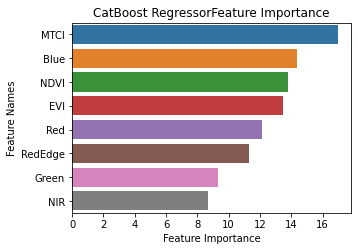

In [36]:
plot_feature_importance(model.get_feature_importance(type='FeatureImportance'),X_train.columns,'CatBoost Regressor')


In [37]:
plot_feature_importance(model.get_feature_importance(Pool(X_test, label=y_test), 
                                                                     type="LossFunctionChange"),X_train.columns,'CatBoost Regressor')


NameError: name 'Pool' is not defined

In [ ]:
import shap

# plot_feature_importance(model.get_feature_importance(Pool(X_test, label=y_test), 
#                                                                      type="LossFunctionChange"),X_train.columns,'CatBoost Regressor')


shap_values = model.get_feature_importance(Pool(X_test, label=y_test), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
plt.clf()
# shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])
shap.summary_plot(shap_values, X_test, plot_type='violin', plot_size=(10,6))
# plt.savefig('Data/shap.pdf',dpi=500, bbox_inches='tight')
plt.savefig("Data/shap.pdf", format='pdf', dpi=1000, bbox_inches='tight')

# shap_values

In [159]:
from catboost import CatBoostClassifier, Pool, cv

shap_values = model.get_feature_importance(Pool(X_test, label=y_test), 
                                                                     type="LossFunctionChange")
# expected_value = shap_values[0,-1]
# shap_values = shap_values[:,:-1]
shap_values
# shap.initjs()
# shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])


array([0.49291013, 4.40737832, 3.48299218, 2.96549773, 3.99118924,
       6.03842516, 9.09193508, 4.40435044])

In [167]:
import nltk
import catboost

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(catboost.__version__))

# The nltk version is 3.0.0.
# The scikit-learn version is 0.15.2.
import sys
print(sys.version)  # parentheses necessary in python 3.       


The nltk version is 3.5.
The scikit-learn version is 0.24.3.
3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]




10 fold cross validation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

model = Lasso(alpha= 4.5)

Standardized data used

alpha from 0.1 to 10 with in incremet of 0.1

max_iter didnt have an impact

R2{1: 0.6165133338737417}


model = RandomForestRegressor(max_depth=250, min_samples_split=14,min_samples_leaf =3, random_state=1, n_jobs = -1)

R2 {0.7359203255994402}

model = GradientBoostingRegressor(subsample=0.8,learning_rate=0.4, random_state=500)

R2 {0.7139824275506774}

model = CatBoostRegressor(depth=8)

R2{1: 0.7134514098951099}
